In [2]:
from importlib import reload

import numpy as np
import matplotlib.pyplot as plt
from structgeo.model import geo
import structgeo.plot as geovis
from structgeo.model import history as geohistory
import structgeo.probability as rv

import pyvista as pv
# Static plots:
pv.set_jupyter_backend('static')
# Dynamic plots:
# pv.set_jupyter_backend('trame')
# pv.set_jupyter_backend('html')


In [3]:
resolution = 128
bounds = ((-20, 20), (-20, 20), (-10, 10))
model = geo.GeoModel(bounds=bounds, resolution=resolution)

window_size = (600,400)

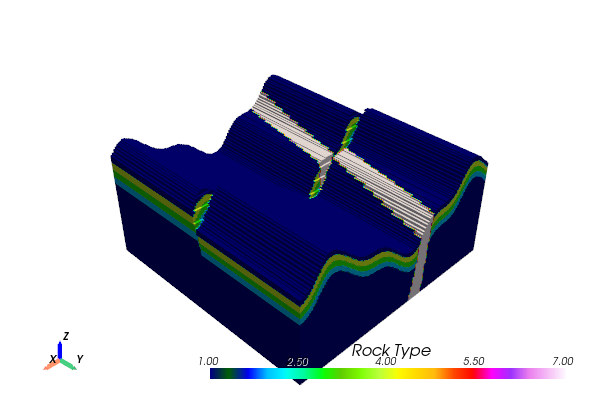

In [4]:

reload(geo)
reload(geovis)

# Bedrock forms the basement layer of the model.  
bedrock = geo.Bedrock(base=-5, value=1)

# Sedimentation is a layer of sedimentary rock that is deposited until reaching a fixed height.
# Sedimentation takes a list of values that represent different types of sedimentary rocks.
# The thickness of eac
sediment0 = geo.Sedimentation(height=0, 
                              value_list=range(1, 5), 
                              )

dike  = geo.Dike(strike=10, dip=80, width=3, origin=(-6, 8, 0), value=7)
tilt = geo.Tilt(strike=0, dip=-10, origin=(0,0,0))
fold = geo.Fold(strike=0, dip=80, rake=0, origin=(0, 0, 0), amplitude=4, period=30, shape=.3)
fault = geo.Fault(strike=90, dip=80, rake=5, amplitude=1.2, origin=(0, 0, 0))

history = [bedrock, sediment0, dike, fold, fault]

model.clear_history()
model.add_history(history)
model.compute_model()
model.renormalize_height(10)
p = geovis.volview(model)
p.window_size = window_size
p.show(jupyter_backend='static')

In [5]:
rand = rv.NonRepeatingRandomListSelector(range(0,4))

for i in range(5):
    print(next(rand))
    


0
1
3
1
0


### Testing wave form generator
Accepts number of harmonics to include and a smoothness factor

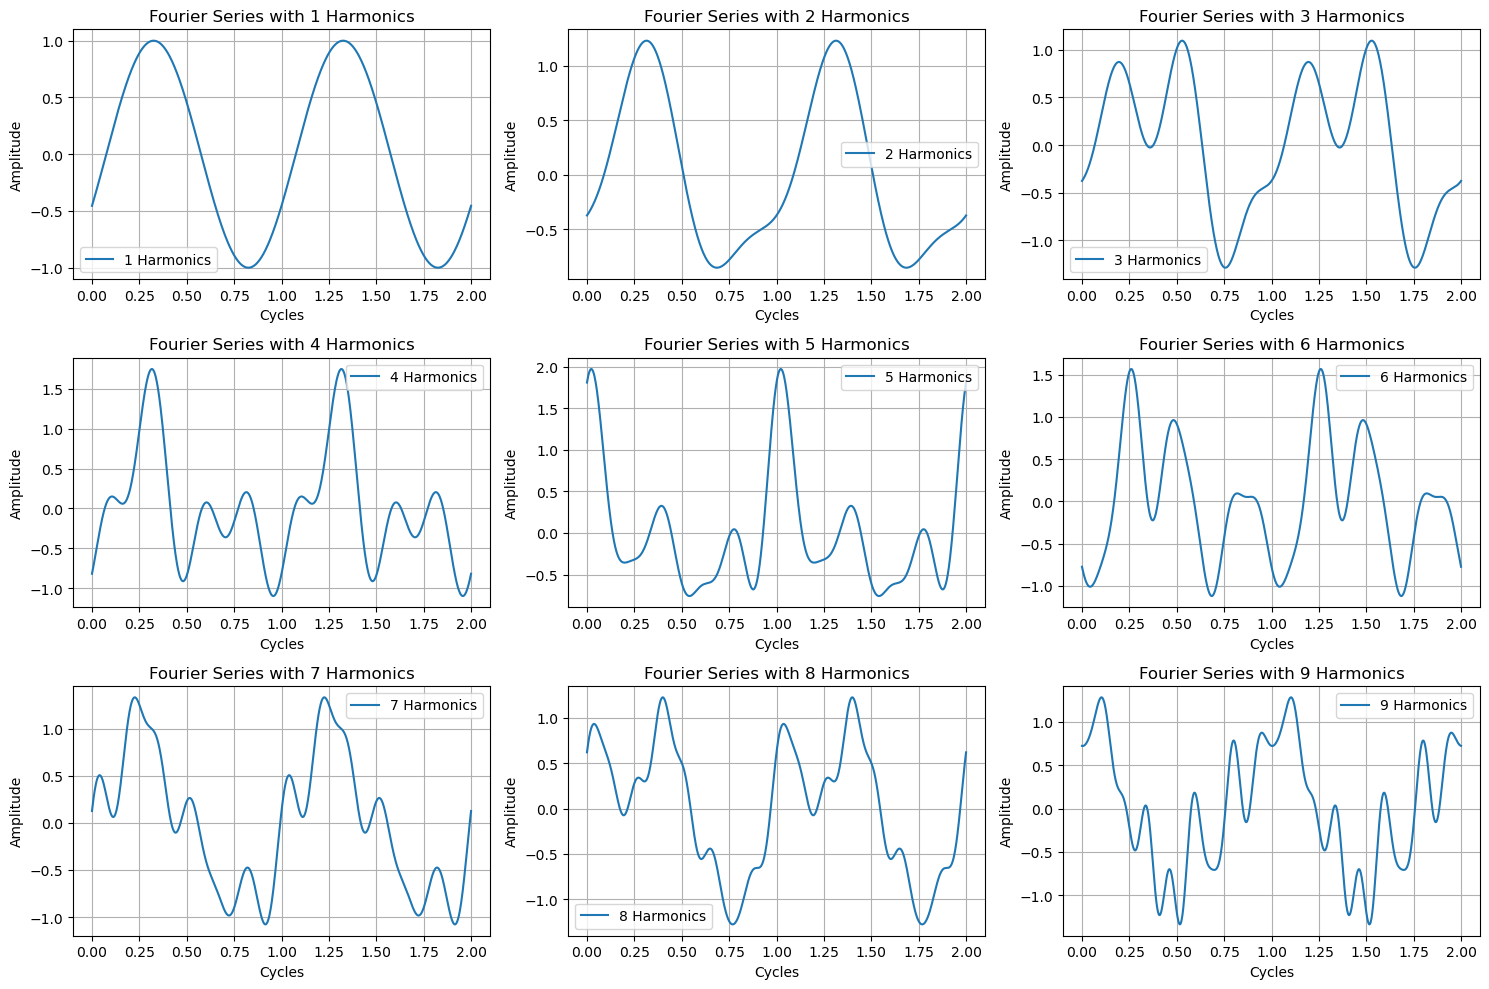

In [6]:
rv = reload(rv)
# Create a figure with a 3x3 grid of subplots
fig, axes = plt.subplots(3, 3, figsize=(15, 10)) 

# Generate waveforms for 1 to 9 harmonics
for i in range(1, 10):
    wave_func = rv.fourier_series_wave(num_harmonics=i, smoothness=.8)
    
    # Create an array of x-values, here corrected to show more cycles
    x = np.linspace(0, 2, 1000)  # Adjust x values to display enough cycles
    y = wave_func(x)  # Evaluate the wave function

    # Find the appropriate subplot (row and column)
    ax = axes[(i-1)//3, (i-1)%3]
    ax.plot(x, y, label=f'{i} Harmonics')
    ax.set_title(f'Fourier Series with {i} Harmonics')
    ax.set_xlabel('Cycles')
    ax.set_ylabel('Amplitude')
    ax.legend()
    ax.grid(True)

# Adjust layout so plots do not overlap
plt.tight_layout()
plt.show()


### Testing feature origin generator

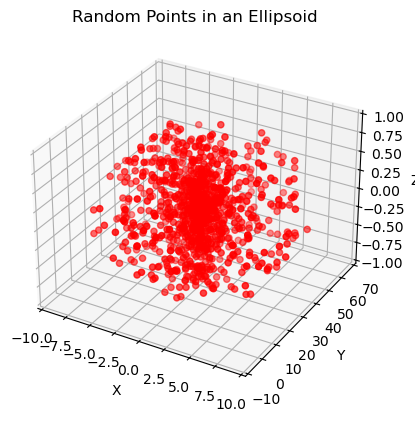

In [7]:
# Define bounds for the ellipsoid
bounds = ((-10, 10), (-10, 70), (-1, 1))

# Generate multiple points
num_points = 1000
points = np.array([rv.random_point_in_ellipsoid(bounds) for _ in range(num_points)])

# Plotting
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(points[:, 0], points[:, 1], points[:, 2], c='r', marker='o')

# Setting equal scaling
ax.set_xlim([bounds[0][0], bounds[0][1]])
ax.set_ylim([bounds[1][0], bounds[1][1]])
ax.set_zlim([bounds[2][0], bounds[2][1]])
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.title('Random Points in an Ellipsoid')
plt.show()



Geological History:
1: Bedrock: with z <= 5.0 and value 1.0



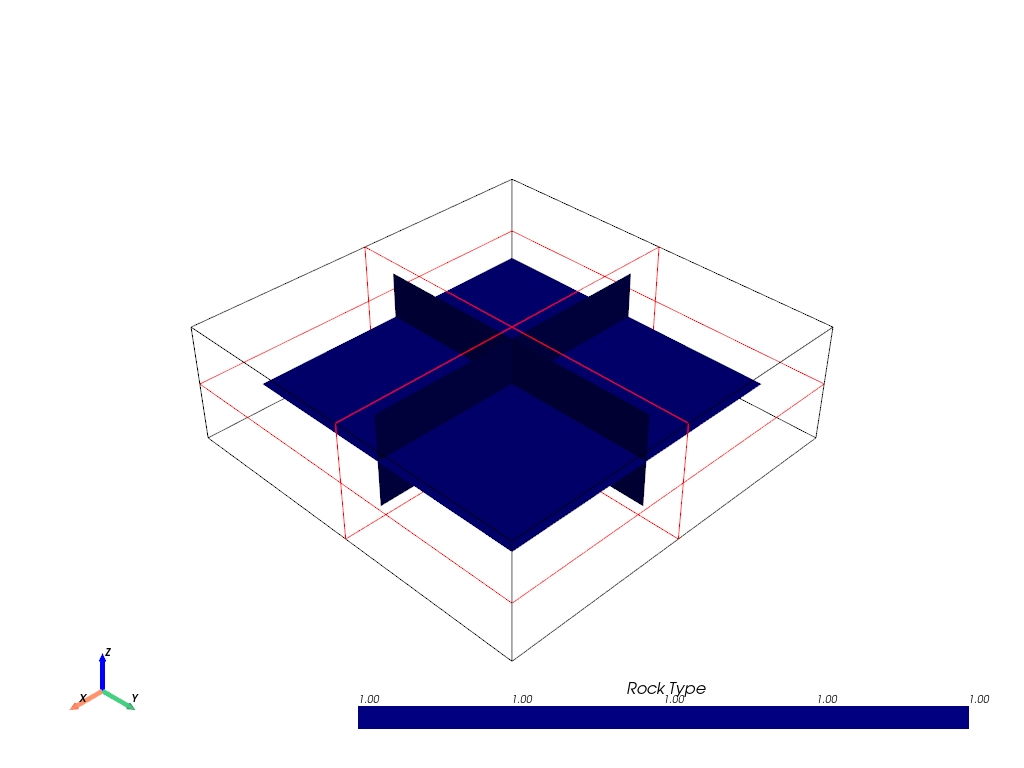

In [15]:

model = geo.GeoModel()
bedrock = geo.Bedrock(base=5, value=1)

model.add_history([bedrock])
print(model.get_history_string())
model.compute_model()
len(model.data)
p = geovis.orthsliceview(model).show(jupyter_backend='static')